In [147]:
import os
import sys
from functools import partial

import IPython
import requests
import numpy as np
import pandas as pd
from PIL import Image
from lxml import etree
from io import BytesIO
try:
    from StringIO import StringIO  # py2
except:
    from io import StringIO  # py3
from bs4 import BeautifulSoup

In [148]:
def getSecurityURL(html):
    img = html.xpath('//img[@id="BookingS1Form_homeCaptcha_passCode"]')
    assert len(img) == 1, 'no valid image'
    img = img[0]
    print("Image: ", img.get('src'))
    return img.get('src')

# Not yet implemented
def Image2Text(im):
    return 'tree'

In [149]:
cities = '南港 台北 板橋 桃園 新竹 苗栗 台中 彰化 雲林 嘉義 台南 左營'.split(' ')
city_map = dict( (loc, i) for i, loc in enumerate(cities))

# consider to use map for efficiency
def parseTime(t):
    hh, mm = t.split(':')
    hh, mm = int(hh), int(mm)
    ap_code = 'N' if t == '12:00' else 'P' if hh >= 12 else 'A'
    hh = 12 if hh == 0 else hh - 12 if hh >= 12 else hh
    return '%d%d%c' % (hh, mm, ap_code)

def packInfo(toDate = '2018/01/01', toTime = '23:30', from_ = '台北', to_ = '台中', tick_n = [0, 0, 0, 0, 1], \
             isStudent = True, securityCode = ''):
    
    seat_base, book_base = 20, 27
    if isStudent:
        seat_base, book_base = seat_base-2, book_base-2
    
    result = {}
    result['selectStartStation'] = city_map[from_]
    result['selectDestinationStation'] = city_map[to_]
    result['trainCon:trainRadioGroup'] = '0'
    result['seatCon:seatRadioGroup'] = 'radio%d' % seat_base
    result['bookingMethod'] = 'radio%d' % book_base
    result['toTimeInputField'] = toDate
    result['toTimeTable'] = parseTime(toTime)
    result['toTrainIDInputField'] = ''
    result['backTimeInputField'] = toDate
    result['backTimeTable'] = ''
    result['backTrainIDInputField'] = ''
    for i, typ in enumerate('FHWEP'):
        result['ticketPanel:rows:%d:ticketAmount'%i] = '%d%s' % (tick_n[i], typ)
    result['homeCaptcha:securityCode'] = securityCode
    result['SubmitButton'] = '開始查詢'
    return result
    

In [150]:
def getStatus(res_root):
    elems = res_root.xpath('//div[@id="error"]/*/ul/li/span[@class="feedbackPanelERROR"]')
    if len(elems) == 0:
        return True
    for elem in elems:
        print('Error: ' + elem.text)
    return False

In [151]:
def packUserInfo(id_, phone_, useId=True, isMobile=True, email=''):
    return {
        'diffOver': '1',
#         'idInputRadio': 'radio33' if useId else 'radio35',
        'idInputRadio:idNumber': id_,
#         'eaiPhoneCon:phoneInputRadio': 'radio44' if isMobile else 'radio41',
        'eaiPhoneCon:phoneInputRadio:phoneNumber': phone_,
        'email': email,
        'agree': 'on',
        'isGoBackM': '',
        'backHome': ''
    }

('Image: ', '/IMINT/;jsessionid=FD4880C72F17FF6C2A28C363E37951A0?wicket:interface=:0:BookingS1Form:homeCaptcha:passCode::IResourceListener&wicket:antiCache=1516547198580')


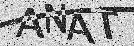

請輸入辨識碼: ANAT

Second Stage


,車次,大學生優惠*,全票優惠*,出發時間,到達時間,行車時間
選擇,,,,,,
NaN,567,,,23:00,23:07,0:07



Final Stage


,行程,日期,車次,起程站,到達站,出發時間,到達時間,全票,敬老、孩童、愛心,大學生優惠,小計
0,去程,01/23,567,台北,板橋,23:00,23:07,-,-,20*1,TWD 20


In [154]:
baseurl = 'https://irs.thsrc.com.tw'
data = packInfo(toDate='2018/01/23', toTime='15:30', from_='台北', to_='板橋')
userInfo = packUserInfo(id_='your idcard', phone_='your phone number')

with requests.Session() as s:
    res = s.get(baseurl + '/IMINT/?student=university')
    
    # parse response HTML
    txt = res.text
    html = etree.HTML(res.text)
    BookingS1Form = html.xpath('//form[@id="BookingS1Form"]')[0]
    hidden1 = BookingS1Form.xpath('.//input[@type="hidden"]')[0].get('name')
    action = BookingS1Form.get('action')
    
    sec_res = s.get(baseurl + getSecurityURL(html))
    sec_image = Image.open(StringIO(sec_res.content))
    IPython.display.display(sec_image)
    
    # identify the securityCode
    securityCode = raw_input('請輸入辨識碼: ') or Image2Text(sec_image)
    data[hidden1] = ''
    data['homeCaptcha:securityCode'] = securityCode
    res_submit = s.post(url=baseurl + action, data=data)
    res_root = etree.HTML(res_submit.text)
    assert getStatus(res_root), 'Error Occur in stage1'
        
    print('\nSecond Stage')
    BookingS2Form = res_root.xpath('//form[@id="BookingS2Form"]')[0]
    hidden2 = BookingS2Form.xpath('.//input[@type="hidden"]')[0].get('name')
    # print table
    df = pd.read_html(etree.tostring(BookingS2Form.xpath('.//table')[0], method='HTML'), 
                      header=0, index_col=0)[0]
    IPython.display.display(df.fillna(''))
    
    # pick one value
    row = BookingS2Form.xpath('//span[@id="BookingS2Form_TrainQueryDataViewPanel"]' \
                            + '/table//tr[not(@class="section_subtitle")]')[0]
    rname = row.xpath('.//input[@name="TrainQueryDataViewPanel:TrainGroup"]')[0].get('value')
    action2 = BookingS2Form.get('action')
    res_submit2 = s.post(url=baseurl + action2, data={
            hidden2: '',
            'TrainQueryDataViewPanel:TrainGroup': rname,
            'SubmitButton': '確認車次'
        })
    res_root = etree.HTML(res_submit2.text)
    assert getStatus(res_root), 'Error Occur in stage2'

    print('\nFinal Stage')
    df = pd.read_html(etree.tostring(res_root.xpath('.//*[@id="content"]//table')[0], method='HTML'), 
                      header=0)[0]
    IPython.display.display(df.fillna('').loc[:0])
    BookingS3FormSP = res_root.xpath('//form[@id="BookingS3FormSP"]')[0]
    hidden3 = BookingS3FormSP.xpath('.//input[@type="hidden"]')[0].get('name')
    action3 = BookingS3FormSP.get('action')
    userInfo[hidden3] = ''
    userInfo['diffOver'] = BookingS3FormSP.xpath('.//input[@name="diffOver"]')[0].get('value')
    id_tags = BookingS3FormSP.xpath('.//input[@name="idInputRadio"]')
    phone_tags = BookingS3FormSP.xpath('.//input[@name="eaiPhoneCon:phoneInputRadio"]')
    userInfo['idInputRadio'] = id_tags[0].get('value')
    userInfo['eaiPhoneCon:phoneInputRadio'] = phone_tags[0].get('value')
    res_submit3 = s.post(url=baseurl + action3, data=userInfo)
    assert getStatus(etree.HTML(res_submit3.text)), 'Error Occur in stage3'


## Form1 Post Response Headers

### Python Requests預設 status=30X 會redirect到該Location

### failed  (從14跳回14)

`
Content-Length:0
Date:Sat, 20 Jan 2018 17:04:56 GMT
Location:https://irs.thsrc.com.tw/IMINT/?wicket:interface=:14::
Set-Cookie:name=value; Secure; HttpOnly
x-content-type-options:nosniff
X-FRAME-OPTIONS:SAMEORIGIN
x-xss-Protection:1; mode=block
`

### success  (從14跳到15)

`Content-Length:0
Date:Sat, 20 Jan 2018 17:07:29 GMT
Location:https://irs.thsrc.com.tw/IMINT/?wicket:interface=:15::
Set-Cookie:name=value; Secure; HttpOnly
x-content-type-options:nosniff
X-FRAME-OPTIONS:SAMEORIGIN
x-xss-Protection:1; mode=block
`

## Form2 post request

` POST2  ex. https://irs.thsrc.com.tw/IMINT/?wicket:interface=:1:BookingS2Form::IFormSubmitListener`

## Data

    BookingS2Form:hf:0: 
    TrainQueryDataViewPanel:TrainGroup:   radio17  # 選車次的樣子 第一個選項是radio17(不一定), 但接下來隨時間越晚遞增
    SubmitButton:                         確認車次  # 那個按鈕的value


## Form3 post request

```html
<form id="BookingS3FormSP" action="/IMINT/?wicket:interface=:7:BookingS3Form::IFormSubmitListener" >...</form>
```

`POST3 : https://irs.thsrc.com.tw/IMINT/?wicket:interface=:7:BookingS3Form::IFormSubmitListener`
### Data                                              
    BookingS3FormSP:hf:0:
    diffOver:                                1            # 隱藏欄位, 從 //form/input[@name="diffOver"] 拿value
    idInputRadio:                            radio33      # 取票識別碼  (radio34 / radio36)
    idInputRadio:idNumber:                                # 身分證號or護照號碼
    eaiPhoneCon:phoneInputRadio:             radio41      # 電話/市話   (radio42 / radio45)
    eaiPhoneCon:phoneInputRadio:phoneNumber:              # 電話號碼
    email:                                                # 就是信箱
    agree:                                   on           # 隱私權條款那個
    isGoBackM:
    backHome:

In [11]:
print etree.tostring(html, pretty_print=True, method='HTML')

<html>
	<head>
		<meta http-equiv="content-type" content="text/html; charset=UTF-8">
		<meta http-equiv="X-UA-Compatible" content="IE=9; IE=8; IE=7">
		<title>&#21488;&#28771;&#39640;&#37941;&#32178;&#36335;&#35330;&#20301; &gt; &#26597;&#35426;&#36554;&#27425;</title>
		<link rel="stylesheet" type="text/css" href="/IMINT/css/site.1.17.css">
	
<meta http-equiv="content-language" content="zh-hant-tw">
<link rel="stylesheet" href="https://ajax.googleapis.com/ajax/libs/jqueryui/1.8.23/themes/base/jquery-ui.css" type="text/css">
<script type="text/javascript" src="https://ajax.googleapis.com/ajax/libs/jquery/1.4.4/jquery.min.js"></script><script type="text/javascript" src="https://ajax.googleapis.com/ajax/libs/jqueryui/1.8.23/jquery-ui.min.js"></script>
<script src="/IMINT/js/irs.2.6.min.js" type="text/javascript"></script>
<script id="tw-com-mitac-webapp-thsr-viewer-Home-0" type="text/javascript">
$(document).ready(function() {
	$(':submit[id!=paidModifySubmit], #SubmitImage').click(funct

## 筆記

#### GET   validation image : https://irs.thsrc.com.tw/IMINT/?wicket:interface=:3:BookingS1Form:homeCaptcha:passCode::IResourceListener&wicket:antiCache=1516463384717

#### POST  to next stage : https://irs.thsrc.com.tw/IMINT/?wicket:interface=:0:BookingS1Form::IFormSubmitListener
#### query string param ( '?'後面那些 )
wicket:interface::0:BookingS1Form::IFormSubmitListener

#### form data :   back開頭都是回程

```
BookingS1Form:hf:0:                  # 隱藏欄位，意義不明
selectStartStation:                  # 出發地 0~11
selectDestinationStation:            # 目的地 0~11
trainCon:trainRadioGroup:0           # 車廂 : 0=普通   1=商務(一般訂票才有)
seatCon:seatRadioGroup:radio18       # 座位喜好
bookingMethod:radio25                # booking method below
toTimeInputField:2018/01/21          # 去程出發日期
toTimeTable:                         # 
toTrainIDInputField:                 
backTimeInputField:2018/01/21        # 回程出發日期
backTimeTable:                       # 回程出發時間
backTrainIDInputField:               
ticketPanel:rows:0:ticketAmount:0F   # 孩童
ticketPanel:rows:1:ticketAmount:0H   # 全票
ticketPanel:rows:2:ticketAmount:0W   # 愛心
ticketPanel:rows:3:ticketAmount:0E   # 敬老
ticketPanel:rows:4:ticketAmount:1P   # 大學生       幾張票決定於前面的數字，後面英文固定
homeCaptcha:securityCode:            # bj4 驗證碼
SubmitButton:開始查詢
```

``` 
booking method 依時間搜尋合適車次 / 直接輸入車次號碼   
一般網路訂票                 radio27 / radio29
大學生優惠                   radio25 / radio27
```

``` 
座位喜好    無       靠窗優先   走道優先
一般網路訂票   radio20 / radio22 / radio24
大學生優惠     radio18 / radio20 / radio22
```


``` 
啟程/到達 站選單代號
<option value="0">南港</option>
<option value="1">台北</option>
<option value="2">板橋</option>
<option value="3">桃園</option>
<option value="4">新竹</option>
<option value="5">苗栗</option>
<option value="6">台中</option>
<option value="7">彰化</option>
<option value="8">雲林</option>
<option value="9">嘉義</option>
<option value="10">台南</option>
<option value="11">左營</option>
```

``` 
時刻 hhmm[PA]   
<option value="1201A">00:00</option>
<option value="1230A">00:30</option>
<option value="600A">06:00</option>
<option value="630A">06:30</option>
<option value="700A">07:00</option>
<option value="730A">07:30</option>
<option value="800A">08:00</option>
<option value="830A">08:30</option>
<option value="900A">09:00</option>
<option value="930A">09:30</option>
<option value="1000A">10:00</option>
<option value="1030A">10:30</option>
<option value="1100A">11:00</option>
<option value="1130A">11:30</option>
<option value="1200N">12:00</option>
<option value="1230P">12:30</option>
<option value="100P">13:00</option>
<option value="130P">13:30</option>
<option value="200P">14:00</option>
<option value="230P">14:30</option>
<option value="300P">15:00</option>
<option value="330P">15:30</option>
<option value="400P">16:00</option>
<option value="430P">16:30</option>
<option value="500P">17:00</option>
<option value="530P">17:30</option>
<option value="600P">18:00</option>
<option value="630P">18:30</option>
<option value="700P">19:00</option>
<option value="730P">19:30</option>
<option value="800P">20:00</option>
<option value="830P">20:30</option>
<option value="900P">21:00</option>
<option value="930P">21:30</option>
<option value="1000P">22:00</option>
<option value="1030P">22:30</option>
<option value="1100P">23:00</option>
<option value="1130P">23:30</option>
```